# Results

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

In [2]:
path_plot = "../plots"

## Dataset

### Read dataset

In [3]:
path = os.path.join("./features.csv")
df = pd.read_csv(path, sep=';', encoding="utf-8", low_memory=False)
print(df.shape)
df.head()

(54263, 22)


,cell_id,cell_name,fov,gene,plate,treatment,well,cell_line,treatment_duration,nb_rna,...,index_mean_distance_centrosome,index_median_distance_centrosome,index_rna_centrosome,proportion_rna_centrosome,index_centrosome_dispersion,key,control,key_label_mitosis_aggregated,label_mitosis,label_mitosis_aggregated
0,11.0,1a_d02_bicd2_untreated_1_11,1.0,bicd2,1a,untreated,d02,endogenous,5mn,40.0,...,0.94,0.95,3.00,0.10,0.92,bicd2_untreated,False,bicd2_untreated_late_mitosis,metaphase,late_mitosis
1,13.0,1a_d02_bicd2_untreated_1_13,1.0,bicd2,1a,untreated,d02,endogenous,5mn,30.0,...,0.77,0.69,2.70,0.07,0.69,bicd2_untreated,False,bicd2_untreated_interphase,interphase,interphase
2,14.0,1a_d02_bicd2_untreated_1_14,1.0,bicd2,1a,untreated,d02,endogenous,5mn,27.0,...,0.76,0.73,1.86,0.11,0.62,bicd2_untreated,False,bicd2_untreated_interphase,interphase,interphase
3,17.0,1a_d02_bicd2_untreated_1_17,1.0,bicd2,1a,untreated,d02,endogenous,5mn,40.0,...,0.86,0.85,2.00,0.12,0.78,bicd2_untreated,False,bicd2_untreated_early_mitosis,prometaphase,early_mitosis
4,18.0,1a_d02_bicd2_untreated_1_18,1.0,bicd2,1a,untreated,d02,endogenous,5mn,16.0,...,0.40,0.50,3.88,0.12,0.17,bicd2_untreated,False,bicd2_untreated_interphase,interphase,interphase


### Explore dataset

In [4]:
print("Interest:")
print(set(df.loc[~df.loc[:, "control"], "gene"]))
print("Control:")
print(set(df.loc[df.loc[:, "control"], "gene"]))

Interest:
{'ccdc88c', 'numa1', 'bicd2', 'hmmr', 'nin', 'aspm', 'cep350', 'pcnt'}
Control:
{'ttbk2', 'tmem237', 'dync1h1', 'kif1c', 'trim59'}


In [5]:
pd.set_option('display.max_rows', 500)
df.loc[:, ["cell_id", "cell_line", "treatment_duration", "plate"]].groupby(
    by=["cell_line", "treatment_duration", "plate"]).count()

cell_id
cell_line  treatment_duration plate         
bac        10mn               6        14618
endogenous 10mn               3a        7930
                              3b       19481
           5mn                1a        5104
                              1b        4377
                              2         2753

In [6]:
df.loc[:, "label_mitosis"].value_counts()

interphase      52911
prometaphase      438
metaphase         426
telophase         298
anaphase          103
prophase           87
Name: label_mitosis, dtype: int64

In [7]:
df.loc[:, "label_mitosis_aggregated"].value_counts()

interphase       52911
late_mitosis       827
early_mitosis      525
Name: label_mitosis_aggregated, dtype: int64

In [8]:
pd.set_option('display.max_rows', 500)
df.loc[:, ["cell_id", "cell_line", "gene", "treatment"]].groupby(
    by=["cell_line", "gene", "treatment"]).count()

cell_id
cell_line  gene    treatment         
bac        aspm    chx           1166
                   puro           934
                   untreated     1422
           hmmr    chx           1426
                   puro          1417
                   untreated     2055
           numa1   chx           2049
                   puro          2133
                   untreated     2016
endogenous bicd2   chx            933
                   puro          1530
                   untreated     2723
           ccdc88c chx           1134
                   puro          1303
                   untreated     3228
           cep350  chx           1001
                   puro          1422
                   untreated     3258
           dync1h1 untreated     1215
           kif1c   untreated      706
           nin     chx           1347
                   puro          1516
                   untreated     3750
           pcnt    chx           1365
                   puro          1207
                   untreated     2748
           tmem237 untreated      225
           trim59  chx           1129
                   puro          1780
                   untreated     3000
           ttbk2   chx            750
                   puro           769
                   untreated     1606

## Plot functions

In [9]:
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

def get_nb_cells(data, keys_distribution, key_feature="key", main_keys=None, sum_gene=False, sum_treatment=False):    
    # parameters warnings
    if sum_gene and sum_treatment:
        raise ValueError("Error 'get_nb_cells'!")
    if main_keys is None and (sum_gene or sum_treatment):
        raise ValueError("Error 'get_nb_cells'!")

    # get number of cells for each key to plot (summed or not)
    x_labels = []
    for key in keys_distribution:
        
        # count cells
        if sum_gene and not sum_treatment:
            gene = key.split("_")[0]
            nb_cells = int(data.loc[data.loc[:, "gene"] == gene, 
                                ["cell_id", "gene"]].groupby("gene").count().sum())
        elif sum_treatment and not sum_gene:
            treatment = key.split("_")[1]
            nb_cells = int(data.loc[data.loc[:, "treatment"] == treatment, 
                                ["cell_id", "treatment"]].groupby("treatment").count().sum())
        else:
            nb_cells = int(data.loc[data.loc[:, key_feature] == key, 
                                    ["cell_id", key_feature]].groupby(key_feature).count().sum())
        
        # create label
        if main_keys is not None and key in main_keys:
            if sum_gene:
                main_key = key.split("_")[0].upper()
            else:
                main_key_ = key.split("_")[1]
                if main_key_ == "untreated": 
                    main_key = "Untreated"
                elif main_key_ == "puro": 
                    main_key = "Puromycin"
                else: 
                    main_key = "Cycloheximide"
            new_label = "{0} - {1} cells".format(main_key, nb_cells)
        elif main_keys is not None and key not in main_keys:
            if sum_gene or sum_treatment:
                new_label = ""
            else:
                new_label = "{0} cells".format(nb_cells)
        else:
            new_label = "{0} cells".format(nb_cells)
        x_labels.append(new_label)

    # create x_ticks
    x_ticks = [i for i in range(len(x_labels))]
    
    return x_ticks, x_labels

def get_whiskers_values(data, feature, key_feature="key"):
    # get whiskers values
    max_value = data.loc[:, feature].max()
    min_value = data.loc[:, feature].min()
    df_whiskers = data.loc[:, [key_feature, feature]].groupby(by=key_feature).agg([q1, q3]).stack(level=0)
    df_whiskers["IQR"] = df_whiskers["q3"] - df_whiskers["q1"]
    df_whiskers["whiskers_top"] = df_whiskers["q3"] + df_whiskers["IQR"] * 1.5
    df_whiskers["whiskers_bottom"] = df_whiskers["q1"] - df_whiskers["IQR"] * 1.5
    max_whiskers_top = min(df_whiskers["whiskers_top"].max(), max_value)
    min_whiskers_bottom = max(df_whiskers["whiskers_bottom"].min(), min_value)
    marge = 5 * max_whiskers_top / 100
    
    return max_whiskers_top, min_whiskers_bottom, marge

def plot_boxplot(data, feature, keys_distribution, ax, show_whisker, show_flier, random_flier, 
                 key_feature="key", hue_feature=None, color=None):
    # boxplot
    boxprops = dict(linestyle='-', linewidth=2, edgecolor='black')
    flierprops = dict(marker='.', markerfacecolor='gray', markersize=5, markeredgecolor='gray')
    medianprops = dict(linestyle='-', linewidth=2, color='black')
    meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
    capprops = dict(linestyle='-', linewidth=1.5, color='grey')
    whiskerprops = dict(linestyle='-', linewidth=1.5, color='grey')
    if hue_feature is None:
        palette = ["#66c2a5", "#fc8d62", "#8da0cb"]
        hue_order = None
    else:
        palette = ["#66c2a5", "#fc8d62", "#8da0cb"]
        hue_order = ["untreated", "chx", "puro"]
    if color is not None:
        palette = color
    if show_whisker:
        sns.boxplot(y=key_feature, x=feature, hue=hue_feature,
                    data=data, order=keys_distribution, hue_order=hue_order, ax=ax,
                    color="#4daf4a", palette=palette, orient="h",
                    showmeans=True, meanline=False, meanprops=meanprops,
                    boxprops=boxprops,
                    showfliers=show_flier, flierprops=flierprops, 
                    medianprops=medianprops, 
                    capprops=capprops,
                    whiskerprops=whiskerprops, whis=1.5)
    else:
        sns.boxplot(y=key_feature, x=feature, hue=hue_feature,
                    data=data, order=keys_distribution, hue_order=hue_order, ax=ax,
                    color="#4daf4a", palette=palette, orient="h",
                    showmeans=True, meanline=False, meanprops=meanprops,
                    boxprops=boxprops,
                    showfliers=show_flier, flierprops=flierprops, 
                    medianprops=medianprops, 
                    showcaps=False, capprops=capprops,
                    whiskerprops=whiskerprops, whis=0)

    # scatter plot
    if random_flier:
        data_ = data.query("{0} in {1}".format(key_feature, keys_distribution))
        int_key = {}
        for i, key in enumerate(keys_distribution):
            int_key[key] = i
        values_y = data_.apply(lambda row: int_key[row[key_feature]], axis=1)
        values_y = np.random.uniform(low=-0.34, high=0.34, size=len(values_y)) + values_y
        values_x = data_.loc[:, feature]
        plt.scatter(x=values_x, y=values_y, c='gray', s=10, alpha=0.1)
        
    return

def format_axes(y_ticks, y_labels, xlim, min_whiskers_bottom, max_whiskers_top, marge, rotation_y=0):
    # axes
    plt.xticks(fontweight="bold", fontsize=15)
    plt.yticks(ticks=y_ticks, labels=y_labels, rotation=rotation_y, fontweight="bold", fontsize=15)
    plt.xlabel("")
    plt.ylabel("")
    if xlim is "auto":
        plt.xlim(min_whiskers_bottom - marge, max_whiskers_top + marge)
    elif isinstance(xlim, tuple):
        plt.xlim(xlim[0], xlim[1])
    plt.ylim(y_ticks[-1] + 0.5, y_ticks[0] - 0.5)

    return

def save_frame(path_output, extension):
    # save frame
    if path_output is not None and extension is not None:
        if isinstance(extension, str):
            path_output_ = path_output + "." + extension 
            plt.savefig(path_output_, format=extension, bbox_inches="tight", dpi="figure")
        elif isinstance(extension, list):
            for extension_ in extension:
                path_output_ = path_output + "." + extension_
                plt.savefig(path_output_, format=extension_, bbox_inches="tight", dpi="figure")
    
    return

## Statistical tests

In [10]:
from scipy.stats import ttest_ind

In [11]:
def welch_t_test(bigger_key, smaller_key, key, feature, data, alpha=0.002, verbose=True, two_tail=True):
    bigger_values = data.loc[data.loc[:, key] == bigger_key, feature]
    smaller_values = data.loc[data.loc[:, key] == smaller_key, feature]
    
    if two_tail:
    
        if verbose:
            print("Feature: {0}".format(feature))
            print("{0}: mean {1:.3f} | std {2:.3f}".format(bigger_key, np.mean(bigger_values), np.std(bigger_values)))
            print("{0}: mean {1:.3f} | std {2:.3f}".format(smaller_key, np.mean(smaller_values), np.std(smaller_values)))
            print("\tH0: {0} == {1}".format(bigger_key, smaller_key))
            print("\tH1: {0} != {1}".format(bigger_key, smaller_key))
        
        t, p = ttest_ind(bigger_values, smaller_values, equal_var=False, nan_policy='raise')
        
        if p < alpha:
            print("\t=> H0 rejected at the significant level {0:.4f} (t statistic {1:.3f} | p-value {2:.4f})".format(alpha, t, p))
        else:
            print("\t=> H0 not rejected at the significant level {0:.4f} (t statistic {1:.3f} | p-value {2:.4f})".format(alpha, t, p))
    
    else:

        if verbose:
            print("Feature: {0}".format(feature))
            print("{0}: mean {1:.3f} | std {2:.3f}".format(bigger_key, np.mean(bigger_values), np.std(bigger_values)))
            print("{0}: mean {1:.3f} | std {2:.3f}".format(smaller_key, np.mean(smaller_values), np.std(smaller_values)))
            print("\tH0: {0} <= {1}".format(bigger_key, smaller_key))
            print("\tH1: {0} > {1}".format(bigger_key, smaller_key))

        if np.mean(smaller_values) > np.mean(bigger_values):
            print("\t=> H0 rejected because {0} is greater than {1}".format(smaller_key, bigger_key))
            return
        else:
            t, p = ttest_ind(bigger_values, smaller_values, equal_var=False, nan_policy='raise')
            p /= 2
            alpha /= 2

        if p < alpha:
            if t > 0:
                print("\t=> H0 rejected at the significant level {0:.3f} (t statistic {1:.3f} | p-value {2:.4f})".format(alpha, t, p))
            else:
                raise ValueError("t statistic: {0:.3f}".format(t))
        else:
            if t > 0:
                print("\t=> H0 not rejected at the significant level {0:.3f} (t statistic {1:.3f} | p-value {2:.4f})".format(alpha, t, p))
            else:
                raise ValueError("t statistic: {0:.3f}".format(t))
                
welch_t_test(bigger_key="bicd2_untreated", smaller_key="bicd2_puro", key="key", 
             feature="proportion_rna_centrosome", data=df)

Feature: proportion_rna_centrosome
bicd2_untreated: mean 0.197 | std 0.110
bicd2_puro: mean 0.069 | std 0.062
	H0: bicd2_untreated == bicd2_puro
	H1: bicd2_untreated != bicd2_puro
	=> H0 rejected at the significant level 0.0020 (t statistic 48.622 | p-value 0.0000)


In [12]:
keys_distributions = [['bicd2_untreated', 'bicd2_puro', True], 
                      ['nin_untreated', 'nin_puro', True],                      
                      ['ccdc88c_untreated','ccdc88c_puro', True],                      
                      ['pcnt_untreated', 'pcnt_puro', True],                       
                      ['cep350_untreated', 'cep350_puro', True],
                      ['hmmr_untreated', 'hmmr_puro', True],
                      ['trim59_untreated','trim59_puro', True],                      
                      ['ttbk2_untreated', 'ttbk2_puro', True]]


for pairs in keys_distributions:
    print("############################################")
    welch_t_test(bigger_key=pairs[0], smaller_key=pairs[1], key="key",
                 feature="proportion_rna_centrosome", data=df, 
                 two_tail=pairs[2], alpha=0.01)
    print("\n")

############################################
Feature: proportion_rna_centrosome
bicd2_untreated: mean 0.197 | std 0.110
bicd2_puro: mean 0.069 | std 0.062
	H0: bicd2_untreated == bicd2_puro
	H1: bicd2_untreated != bicd2_puro
	=> H0 rejected at the significant level 0.0100 (t statistic 48.622 | p-value 0.0000)


############################################
Feature: proportion_rna_centrosome
nin_untreated: mean 0.162 | std 0.101
nin_puro: mean 0.067 | std 0.059
	H0: nin_untreated == nin_puro
	H1: nin_untreated != nin_puro
	=> H0 rejected at the significant level 0.0100 (t statistic 42.340 | p-value 0.0000)


############################################
Feature: proportion_rna_centrosome
ccdc88c_untreated: mean 0.081 | std 0.087
ccdc88c_puro: mean 0.050 | std 0.064
	H0: ccdc88c_untreated == ccdc88c_puro
	H1: ccdc88c_untreated != ccdc88c_puro
	=> H0 rejected at the significant level 0.0100 (t statistic 13.304 | p-value 0.0000)


############################################
Feature: proport

In [13]:
keys_distributions = [['bicd2_untreated', 'bicd2_chx', True],
                      ['nin_untreated', 'nin_chx', True],
                      ['ccdc88c_untreated', 'ccdc88c_chx', True],
                      ['pcnt_untreated', 'pcnt_chx', True],
                      ['cep350_untreated', 'cep350_chx', True],
                      ['hmmr_untreated', 'hmmr_chx', True],
                      ['trim59_untreated', 'trim59_chx', True],
                      ['ttbk2_untreated', 'ttbk2_chx', True]]


for pairs in keys_distributions:
    print("############################################")
    welch_t_test(bigger_key=pairs[0], smaller_key=pairs[1], key="key",
                 feature="proportion_rna_centrosome", data=df, 
                 two_tail=pairs[2], alpha=0.01)
    print("\n")

############################################
Feature: proportion_rna_centrosome
bicd2_untreated: mean 0.197 | std 0.110
bicd2_chx: mean 0.207 | std 0.110
	H0: bicd2_untreated == bicd2_chx
	H1: bicd2_untreated != bicd2_chx
	=> H0 not rejected at the significant level 0.0100 (t statistic -2.514 | p-value 0.0120)


############################################
Feature: proportion_rna_centrosome
nin_untreated: mean 0.162 | std 0.101
nin_chx: mean 0.159 | std 0.094
	H0: nin_untreated == nin_chx
	H1: nin_untreated != nin_chx
	=> H0 not rejected at the significant level 0.0100 (t statistic 0.955 | p-value 0.3395)


############################################
Feature: proportion_rna_centrosome
ccdc88c_untreated: mean 0.081 | std 0.087
ccdc88c_chx: mean 0.122 | std 0.103
	H0: ccdc88c_untreated == ccdc88c_chx
	H1: ccdc88c_untreated != ccdc88c_chx
	=> H0 rejected at the significant level 0.0100 (t statistic -12.074 | p-value 0.0000)


############################################
Feature: proporti

## Plots

In [14]:
def plot_final(feature, data,
               figsize=(15, 10), xlim="auto", vertical_line=None,
               show_whisker=False, show_flier=False, random_flier=True,
               path_output=None, extension=None):

    # parameters
    genes_interest = [
        'bicd2', 
        'nin', 
        'ccdc88c',
        'pcnt', 
        'cep350',
        'hmmr']
    
    genes_control = [
        'trim59',
        'ttbk2',
        'kif1c',
        'dync1h1']
    genes = genes_interest + genes_control
    
    keys_distribution = []
    main_keys = []
    for gene in genes:
        for treatment in ["untreated", "puro", "chx"]:
            if gene in ["kif1c", "dync1h1"] and treatment in ["puro", "chx"]:
                continue
            key = "{0}_{1}".format(gene, treatment)
            keys_distribution.append(key)
            if gene in ["kif1c", "dync1h1"] and treatment == "untreated":
                main_keys.append(key)
            elif treatment == "puro":
                main_keys.append(key)
    
    # get number of cells labels and colors
    y_ticks, y_labels = get_nb_cells(
        data=data, 
        keys_distribution=keys_distribution, 
        key_feature="key", 
        main_keys=main_keys, 
        sum_gene=True, 
        sum_treatment=False)
    
    palette = ["#66c2a5", "#fc8d62", "#8da0cb",
               "#66c2a5", "#fc8d62", "#8da0cb",
               "#66c2a5", "#fc8d62", "#8da0cb",
               "#66c2a5", "#fc8d62", "#8da0cb",
               "#66c2a5", "#fc8d62", "#8da0cb",
               "#66c2a5", "#fc8d62", "#8da0cb",
               "#66c2a5", "#fc8d62", "#8da0cb",
               "#66c2a5", "#fc8d62", "#8da0cb",
               "#66c2a5", "#66c2a5"]
    
    # get whiskers values
    max_whiskers_top, min_whiskers_bottom, marge = get_whiskers_values(
        data=data, 
        feature=feature,
        key_feature="key")

    # plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # boxplot
    plot_boxplot(
        data=data, 
        feature=feature, 
        keys_distribution=keys_distribution, 
        ax=ax, 
        show_whisker=show_whisker, 
        show_flier=show_flier, 
        random_flier=random_flier,
        key_feature="key",
        hue_feature=None,
        color=palette)

    # lines
    for i in range(2, 23, 3):
        plt.axhline(y=i+0.5, c="firebrick", linewidth=2, linestyle=":")
    plt.axhline(y=24.5, c="firebrick", linewidth=2, linestyle=":")
    plt.axhline(y=14.5, c="firebrick", linewidth=4)
    plt.axhline(y=17.5, c="firebrick", linewidth=4)
    plt.axhline(y=23.5, c="firebrick", linewidth=4)

    if vertical_line is not None:
        plt.axvline(x=vertical_line, c="steelblue", lw=2, ls="dashed")

    # background color
    plt.axhspan(14.5, 17.5, facecolor="lightgray", alpha=0.5)

    # axes
    format_axes(
        y_ticks=y_ticks, 
        y_labels=y_labels, 
        xlim=xlim, 
        min_whiskers_bottom=min_whiskers_bottom, 
        max_whiskers_top=max_whiskers_top, 
        marge=marge)

    legend_untreated = Patch(facecolor="#66c2a5", edgecolor="black", label="Untreated")
    legend_puro = Patch(facecolor="#fc8d62", edgecolor="black", label="Puromycin (10mn)")
    legend_chx = Patch(facecolor="#8da0cb", edgecolor="black", label="Cycloheximide (10mn)")
    legend_elements = [legend_untreated, legend_puro, legend_chx]
    plt.legend(handles=legend_elements, prop={'size': 15})

    plt.tight_layout()
    
    # save frame
    save_frame(
        path_output=path_output, 
        extension=extension)
    
    # show frame
    plt.show()
    
    return

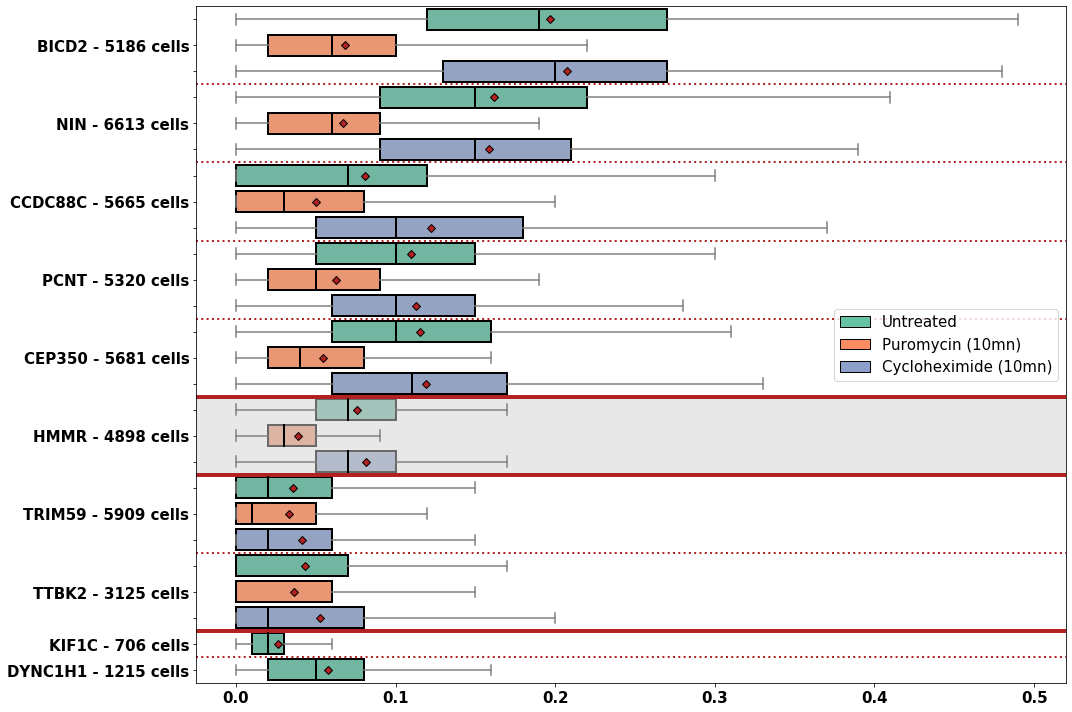

In [15]:
path = os.path.join(path_plot, "all_proportion_rna_centrosome")
plot_final("proportion_rna_centrosome", df,
           figsize=(15, 10), xlim="auto", vertical_line=None,
           show_whisker=True, show_flier=False, random_flier=False,
           path_output=path, extension=["png", "pdf"])